In [356]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


commune=pd.read_parquet('donnee-comm-data.gouv-parquet-2023-geographie2024-produit-le2024-07-05.parquet')
dep=pd.read_csv('donnee-dep-data.gouv-2023-geographie2024-produit-le2024-07-05.csv',sep=';')
reg=pd.read_csv('donnee-reg-data.gouv-2023-geographie2024-produit-le2024-07-05.csv',sep=';')
commune.tail(1)

,CODGEO_2024,annee,classe,unité.de.compte,valeur.publiée,faits,tauxpourmille,complementinfoval,complementinfotaux,POP,millPOP,LOG,millLOG
3917759,97617,23,Usage de stupéfiants,Mis en cause,ndiff,NaN,NaN,7.5,0.673906,13934,17,3872.0,17


In [358]:
#Recherche de doublons 
commune.duplicated().sum()
dep.duplicated().sum()
reg.duplicated().sum()
print("Il n'y a aucun doublon dans les 3 bases de données")

Il n'y a aucun doublon dans les 3 bases de données


In [372]:
#Recherche de valeurs manquantes sur les colonnes 
dep.isna().any(axis = 0) # Aucune valeur manquante
reg.isna().any(axis = 0) # Aucune valeur manquante
commune.isna().any(axis = 0) # Valeur manquantes dans les colonnes faits, taux pour mille, complementinfoval, complementinfototaux

CODGEO_2024           False
annee                 False
classe                False
unité.de.compte       False
valeur.publiée        False
faits                  True
tauxpourmille          True
complementinfoval      True
complementinfotaux     True
POP                   False
millPOP               False
LOG                   False
millLOG               False
dtype: bool

In [362]:
#Recherche de valeurs manquantes sur les lignes 
dep.isna().any(axis = 1).sum() #Aucune valeur manquante
reg.isna().any(axis = 1).sum() #Aucune valeur manquante
commune.isna().any(axis = 1).sum() #3917760 sur 3917760 = chaque ligne comporte au moins une valeur manquante

3917760

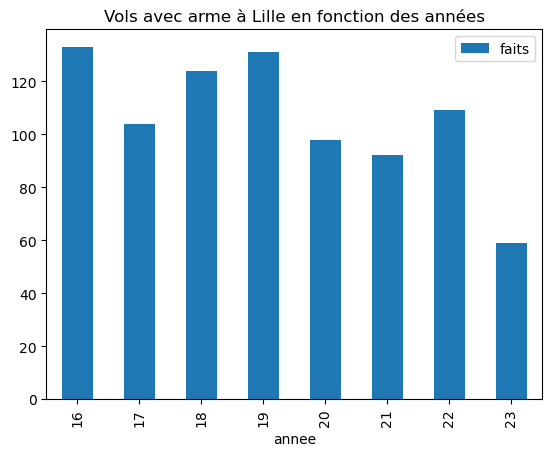

In [370]:
#Je me demande combien il y a eu d'homicide à Lille 59350 sur 2023 
commune['classe'] = commune['classe'].astype('str') #Changement de type
commune['unité.de.compte'] = commune['unité.de.compte'].astype('str')
commune["unité.de.compte"].unique()
com2=commune.loc[(commune["classe"]=="Vols avec armes") & (commune["CODGEO_2024"]== "59350")]
com2.head(8).plot.bar(x = "annee",y=["faits"])
plt.title("Vols avec arme à Lille en fonction des années");

